# Extract data within a boundary
> History | Updated Sep 2023  

## Background
One use for satellite observations is to supplement in situ sampling of geographical locations where the timespan or frequency measurements, or spatial dimensions or remoteness of the locations, make physical sampling impossible or impractical. One drawback is that satellite data are often rectangular, whereas geographical locations can have irregular boundaries. Examples of locations with boundaries include Marine Protected Areas or marine physical, biological, and ecological divisions like the Longhurst Marine Provinces.  

## Objectives
In this tutorial we will learn how to download a timeseries of SST satellite data from an ERDDAP server, and then mask the data to retain only the data within an irregular geographical boundary (polygon). We will then plot a yearly seasonal cycle from within the boundary. 

## The tutorial demonstrates the following techniques
-   Downloading data from an ERDDAP data server
-   Visualizing data on a map
-   Masking satellite data using a shape file

## Datasets used
__NOAA Geo-polar Blended Analysis Sea-Surface Temperature, Global, Monthly, 5km, 2019-Present__    
The NOAA geo-polar blended SST is a high resolution satellite-based sea surface temperature (SST) product that combines SST data from US, Japanese and European geostationary infrared imagers, and low-earth orbiting infrared (U.S. and European) SST data, into a single product. We will use the monthly composite.
https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW_monthly

__Longhurst Marine Provinces__  
The dataset represents the division of the world oceans into provinces as defined by Longhurst (1995; 1998; 2006). This division has been based on the prevailing role of physical forcing as a regulator of phytoplankton distribution. The Longhurst Marine Provinces dataset is available online (https://www.marineregions.org/downloads.php) and within the shapes folder associated with this repository. For this tutorial we will use the Gulf Stream province (ProvCode: GFST)  

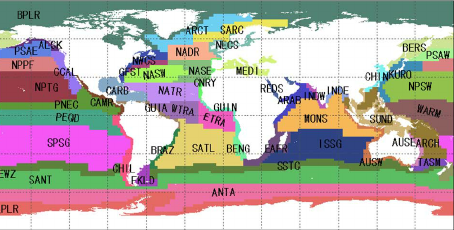

## Import packages
Note: Make sure you have at least version 0.10.0 of regionmask
* To install with conda use "conda install -c conda-forge regionmask=0.10.0 cartopy"

In [3]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
import os
warnings.filterwarnings('ignore')

## Load the Longhurst Provinces shape files into a geopandas dataframe

In [5]:
#shape_path = '../resources/longhurst_v4_2010/Longhurst_world_v4_2010.shp'
shape_path = os.path.join('..',
                          'resources',
                          'longhurst_v4_2010',
                          'Longhurst_world_v4_2010.shp'
                          )
shapefiles = geopandas.read_file(shape_path)
shapefiles.head(8)

,ProvCode,ProvDescr,geometry
0,BPLR,Polar - Boreal Polar Province (POLR),"MULTIPOLYGON (((-161.18426 63.50000, -161.5000..."
1,ARCT,Polar - Atlantic Arctic Province,"MULTIPOLYGON (((-21.51305 64.64409, -21.55945 ..."
2,SARC,Polar - Atlantic Subarctic Province,"MULTIPOLYGON (((11.26472 63.96082, 11.09548 63..."
3,NADR,Westerlies - N. Atlantic Drift Province (WWDR),"POLYGON ((-11.50000 57.50000, -11.50000 56.500..."
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.50000 43.50000, -43.50000 42.500..."
5,NASW,Westerlies - N. Atlantic Subtropical Gyral Pro...,"POLYGON ((-39.50000 25.50000, -40.50000 25.500..."
6,NATR,Trades - N. Atlantic Tropical Gyral Province (...,"MULTIPOLYGON (((-72.34673 18.53597, -72.36877 ..."
7,WTRA,Trades - Western Tropical Atlantic Province,"POLYGON ((-19.50000 -6.50000, -20.50000 -6.500..."


## Isolate the Gulf Stream Province
The Gulf Stream Province can be isolated using its ProvCode (GFST)

In [3]:
ProvCode = "GFST"

# Locate the row with the ProvCode code
gulf_stream = shapefiles.loc[shapefiles["ProvCode"] == ProvCode]
gulf_stream

,ProvCode,ProvDescr,geometry
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.50000 43.50000, -43.50000 42.500..."


## Find the coordinates of the bounding box
* The bounding box is the smallest rectangle that will completely enclose the province. 
* We will use the bounding box coordinates to subset the satellite data 

In [4]:
gs_bnds = gulf_stream.bounds
gs_bnds

,minx,miny,maxx,maxy
4,-73.5,33.5,-43.5,43.5


## Open the satellite dataset into a xarray dataset object

In [6]:
erddap_url = '/'.join(['https://coastwatch.pfeg.noaa.gov',
                       'erddap',
                       'griddap',
                       'NOAA_DHW_monthly'
                       ])

ds = xr.open_dataset(erddap_url)
ds

<xarray.Dataset>
Dimensions:                          (time: 464, latitude: 3600, longitude: 7200)
Coordinates:
  * time                             (time) datetime64[ns] 1985-01-16 ... 202...
  * latitude                         (latitude) float32 89.97 89.93 ... -89.97
  * longitude                        (longitude) float32 -180.0 -179.9 ... 180.0
Data variables:
    sea_surface_temperature          (time, latitude, longitude) float32 ...
    mask                             (time, latitude, longitude) float32 ...
    sea_surface_temperature_anomaly  (time, latitude, longitude) float32 ...
Attributes: (12/66)
    _NCProperties:                    version=2,netcdf=4.8.1,hdf5=1.12.2
    acknowledgement:                  NOAA Coral Reef Watch program
    cdm_data_type:                    Grid
    comment:                          This is a product of NOAA Coral Reef Wa...
    contributor_name:                 NOAA Coral Reef Watch program
    contributor_role:                 Collecting source data and deriving pro...
    ...                               ...
    time_coverage_duration:           P1M
    time_coverage_end:                2023-08-16T00:00:00Z
    time_coverage_resolution:         P1M
    time_coverage_start:              1985-01-16T00:00:00Z
    title:                            SST and SST Anomaly, NOAA Global Coral ...
    Westernmost_Easting:              -179.975

## Subset the satellite data
* Use the bounding box coordinates for the latitude and longitude slices
* Select the entire year of 2020

In [7]:
# This dataset has latitude in descending order. 
# Therefore use maxy first and miny last to slice latitude
ds_subset = ds['sea_surface_temperature'].sel(time=slice("2020-01-16", "2020-12-16"),
                                              latitude=slice(gs_bnds.maxy.item(), 
                                                             gs_bnds.miny.item()),
                                              longitude=slice(gs_bnds.minx.item(), 
                                                              gs_bnds.maxx.item())
                                            )
ds_subset

<xarray.DataArray 'sea_surface_temperature' (time: 12, latitude: 200,
                                             longitude: 600)>
[1440000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2020-01-16 2020-02-16 ... 2020-12-16
  * latitude   (latitude) float32 43.47 43.43 43.38 43.33 ... 33.62 33.58 33.53
  * longitude  (longitude) float32 -73.47 -73.42 -73.38 ... -43.62 -43.57 -43.53
Attributes:
    colorBarMaximum:        32.0
    colorBarMinimum:        0.0
    coverage_content_type:  physicalMeasurement
    ioos_category:          Temperature
    long_name:              analysed sea surface temperature
    standard_name:          sea_surface_temperature
    units:                  degree_C
    valid_max:              50.0
    valid_min:              -2.0

## Visualize the unmasked data on a map
The map shows the full extent of the bounding box

Text(0.5, 1.0, 'Satellite Data Before Masking')

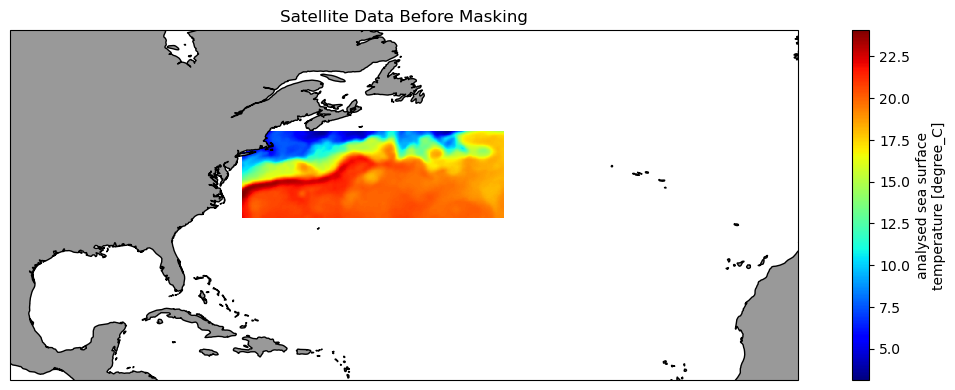

In [8]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([260, 350, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents

# add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

ds_subset[0].plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap='jet')

plt.title('Satellite Data Before Masking')


## Create the region from the shape file
The plot shows the shape of the region and its placement along the US East Coast. 

<GeoAxesSubplot:>

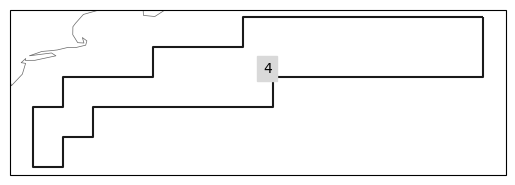

In [9]:
region = regionmask.from_geopandas(gulf_stream)
region.plot()



## Mask the satellite data


In [10]:
# Create the mask
mask = region.mask(ds_subset.longitude, ds_subset.latitude)

# Apply mask the the satellite data
masked_ds = ds_subset.where(mask == region.numbers[0])


## Visualize the masked data on a map
These data have been trimmed to contain only values within the Gulf Stream Province

Text(0.5, 1.0, 'Satellite Data After Masking for Longhurst GFST')

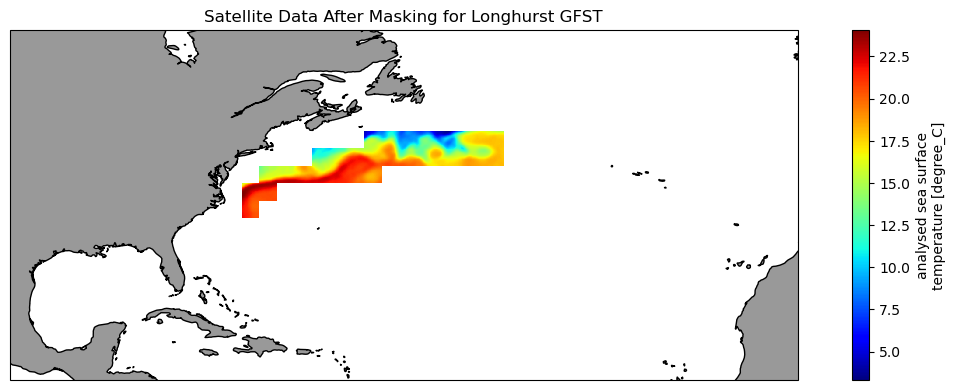

In [11]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([260, 350, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents

# add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

masked_ds[0].plot.pcolormesh(ax=ax1,
                             transform=ccrs.PlateCarree(),
                             cmap='jet')

plt.title('Satellite Data After Masking for Longhurst GFST')



## Plot the mean seasonal temperature for the province

In [12]:
gulf_stream_mean = masked_ds.mean(dim=['latitude', 'longitude'])

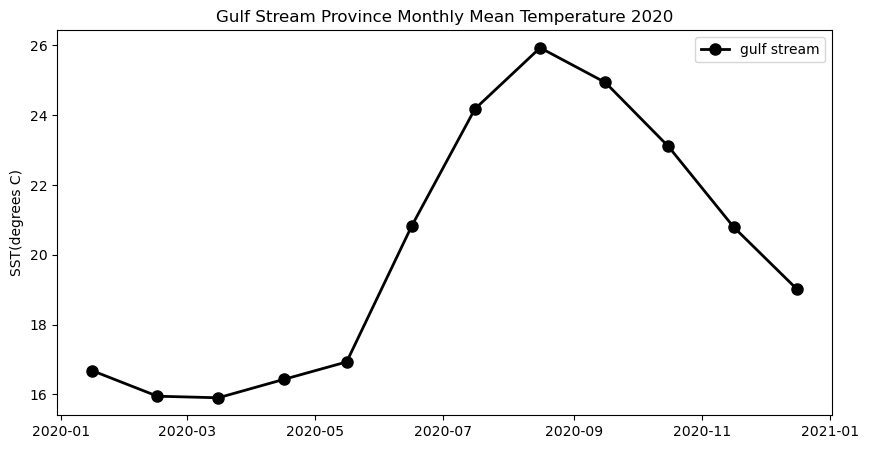

In [13]:
gulf_stream_mean

plt.figure(figsize=(10, 5)) 
# Plot the SeaWiFS data
plt.plot_date(gulf_stream_mean.time,
              gulf_stream_mean, 
              'o', markersize=8, 
              label='gulf stream', c='black', 
              linestyle='-', linewidth=2) 

plt.title('Gulf Stream Province Monthly Mean Temperature 2020')
plt.ylabel('SST(degrees C)') 
plt.legend()

## References
The several CoastWatch Node websites have data catalog containing documentation and links to all the datasets available:  
    * https://oceanwatch.pifsc.noaa.gov/doc.html  
    * https://coastwatch.pfeg.noaa.gov/data.html  
    * https://polarwatch.noaa.gov/catalog/  

Sources for marine shape files
* https://www.marineregions.org/downloads.php